In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.func import vmap, jacrev
from tqdm import tqdm
import os
import random
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import Callback
import math
from pydmd import DMD
from sklearn.preprocessing import MinMaxScaler
import warnings
from matplotlib.font_manager import FontProperties

In [2]:
class ResidualFlow(nn.Module):
    def __init__(self, dim, hidden_dim, n_layers, input_dim=0, dropout=0, LDJ=False, block_id=0):
        super().__init__()
        self.dim = dim
        self.input_dim = input_dim
        self.LDJ = LDJ
        self.block_id = block_id

        flip = (block_id % 2 == 0)
        self.flow = Flow(dim, hidden_dim, flip=flip)

    def forward(self, x, reverse=False):
        x_e = x
        if not reverse:
            y = self.flow(x_e, reverse=False)
            logdet = 0
            return y, logdet
        else:
            y = self.flow(x_e, reverse=True)
            return y

class Flow(nn.Module):
    def __init__(self, in_channel, hidden_dim, flip=False):
        super().__init__()
        self.coupling = AffineCoupling(in_channel, hidden_dim, flip)

    def forward(self, x, reverse=False):
        return self.coupling(x, reverse)

class AffineCoupling(nn.Module):
    def __init__(self, dim, hidden_dim, flip=False):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.flip = flip

        self.split_idx = dim // 2
        self.rest_dim = dim - self.split_idx

        self.net = nn.Sequential(
            nn.Linear(self.split_idx, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.rest_dim * 2)
        )

    def forward(self, x, reverse=False):
        if self.flip:
            x2, x1 = torch.split(x, [self.rest_dim, self.split_idx], dim=-1)
        else:
            x1, x2 = torch.split(x, [self.split_idx, self.rest_dim], dim=-1)

        h = self.net(x1)
        s, t = torch.chunk(h, 2, dim=-1)
        s = torch.tanh(s)

        if not reverse:
            y2 = x2 * torch.exp(s) + t
        else:
            y2 = (x2 - t) * torch.exp(-s)

        if self.flip:
            return torch.cat([y2, x1], dim=-1)
        else:
            return torch.cat([x1, y2], dim=-1)
    
class InvertibleNN(nn.Module):
    def __init__(self, dim, hidden_dim, n_blocks, n_layers, input_dim=0, dropout=0, LDJ=False):
        super(InvertibleNN, self).__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.n_blocks = n_blocks
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.blocks = nn.ModuleList([ResidualFlow(self.dim, self.hidden_dim, self.n_layers, self.input_dim, dropout, LDJ, block_id=i) for i in range(self.n_blocks)])
    
    def forward(self, x, u=None, reverse=False):
        if not reverse:
            ldj_total = 0
            for block in self.blocks:
                x, ldj = block(x, reverse)
                ldj_total += ldj
            return x, ldj_total
        else:
            for block in reversed(self.blocks):
                x = block(x, reverse)
            return x
    
class CombinedNetwork(nn.Module):
    def __init__(self, inn_model, input_dim, lifted_dim):
        super(CombinedNetwork, self).__init__()
        self.input_dim = input_dim
        self.inn_model = inn_model  
        self.lifted_dim = lifted_dim
        self.K = nn.Parameter(torch.randn(input_dim + lifted_dim, input_dim + lifted_dim), requires_grad=True)
    
    def forward(self, x, u=None, reverse=False):
        x = x.float()
        if not reverse:
            zero_pad = torch.zeros(x.shape[0], x.shape[1], self.lifted_dim, device=x.device)
            x = torch.cat((x, zero_pad), dim=-1)
            x, ldj = self.inn_model(x, u, reverse)
            return x, ldj
        else:
            x = self.inn_model(x, u, reverse)
            x = x[:, :self.input_dim]
            return x

In [3]:
def dmd(model, X):
    GX_pred_list = []
    GX_list = []
    GX, ldj = model(X)
    for i in range(X.shape[0]):
        GX_temp = GX[i, :, :].T
        GX_pred = model.K @ GX_temp[:, :-1]
        GX_pred_list.append(GX_pred)
        GX_list.append(GX_temp[:, 1:])
    GX_pred = torch.cat(GX_pred_list, dim=-1)
    GX = torch.cat(GX_list, dim=1)

    return GX, GX_pred, ldj

In [4]:
class TrainModel(pl.LightningModule):
    def __init__(self, model, train_dataset, learning_rate=1e-3, lamb=1, path="model_checkpoint_NP"):
        super(TrainModel, self).__init__()
        self.model = model
        self.train_dataset = train_dataset
        self.learning_rate = learning_rate
        self.criterion = nn.MSELoss()
        self.best_val_loss = float('inf')
        self.validation_outputs = []
        self.lamb = lamb
        self.train_losses = []
        self.path = path+'.ckpt'

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        X_batch = batch[0]
        GY, GY_pred, ldj = dmd(self.model, X_batch)

        loss_lin = self.criterion(GY, GY_pred.detach())
        loss_LDJ = ldj / X_batch.numel()

        loss = loss_lin - self.lamb * loss_LDJ
        self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        Z_batch = batch[0]
        Z1, Z_pred, _ = dmd(self.model, Z_batch)
        Z_pred = self.model(Z_pred.T, reverse=True)
        Z1 = self.model(Z1.T, reverse=True)
        valid_loss = self.criterion(Z_pred, Z1)

        self.validation_outputs.append(valid_loss)
        self.log('val_loss', valid_loss)
        return valid_loss

    def test_step(self, batch, batch_idx):
        Z_batch = batch[0]
        Z1, Z_pred, _ = dmd(self.model, Z_batch)
        Z_pred = self.model(Z_pred.T, reverse=True)
        Z1 = self.model(Z1.T, reverse=True)
        test_loss = self.criterion(Z_pred, Z1)

        self.log('test_loss', test_loss)
        return test_loss
    
    def on_train_batch_end(self, outputs, batch, batch_idx):
        with torch.no_grad():  
            for name, module in self.model.named_modules():  
                if isinstance(module, nn.Linear): 
                    if name == "linear":  
                        continue
                    weight = module.weight  
                    sigma_max = torch.linalg.norm(weight, ord=2)  
                    if sigma_max >= 1 - 1e-2:  
                        scale = (1 - 1e-2) / sigma_max
                        module.weight.data *= scale
    
    def on_train_epoch_start(self):
        if os.path.exists(self.path):
            best_state_dict = torch.load(self.path)["state_dict"]
            self.load_state_dict(best_state_dict)
    
    def on_train_epoch_end(self):
        device = self.model.K.device
        self.model.eval() 
        with torch.no_grad():
            x_all = self.train_dataset.tensors[0].to(device)  

            gx_all = self.model(x_all)[0].detach()[:, :-1, :] 
            gy_all = self.model(x_all)[0].detach()[:, 1:, :]

            gx_all = gx_all.reshape(-1, gx_all.shape[-1])
            gy_all = gy_all.reshape(-1, gy_all.shape[-1])

        optimizer_K = torch.optim.Adam([self.model.K], lr=1e-3)
        for _ in range(100):  
            optimizer_K.zero_grad()
            gx_pred = gx_all @ self.model.K
            loss_K = self.criterion(gx_pred, gy_all)
            loss_K.backward()
            optimizer_K.step()
            with torch.no_grad():
                radius = torch.linalg.norm(self.model.K.data, ord=2)
                if radius > 1.0:
                    self.model.K.data /= radius

    def on_validation_epoch_end(self):
        avg_val_loss = torch.stack(self.validation_outputs).mean() 
        self.log('avg_val_loss', avg_val_loss)
        self.validation_outputs.clear()
        print(f"Validation loss: {avg_val_loss}")
        with open("loss_log.txt", "a") as f:
            f.write(f"{avg_val_loss.item()}\n")

    def configure_optimizers(self):
        g_params = [p for n, p in self.model.named_parameters() if "K" not in n]
        optimizer = torch.optim.AdamW(g_params, lr=self.learning_rate, weight_decay=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=100,
            gamma=0.5
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss", 
            },
            "gradient_clip_val": 1.0,  
            "gradient_clip_algorithm": "norm",
        }

In [51]:
dim = 1 
hidden_dim = 80
input_dim = 0
n_blocks = 20 
n_feature = 19
batch_size = 64
# n_train = 6400
n_train = 1
# n_valid = 1000
n_test = 1
dropout = 0
num_epochs = 1000 
lamb = 0
learning_rate = 1e-3 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
X_train = pd.read_csv('y_train.csv', header=None).values.astype(float)
length = X_train.shape[1] // n_train
H_train = []
for i in range(n_train):
    H_train.append(X_train[:, i*length:(i+1)*length])
H_train = np.stack([H_train[idx].T for idx in range(n_train)], axis=0)
train_dataset = TensorDataset(torch.tensor(H_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

In [72]:
inn_model = InvertibleNN(dim=dim+input_dim+n_feature, hidden_dim=hidden_dim, n_blocks=n_blocks, n_layers=1, input_dim=input_dim, dropout=dropout, LDJ=lamb>0)
model = CombinedNetwork(inn_model=inn_model, input_dim=dim+input_dim, lifted_dim=n_feature)
path = "model_checkpoint_Wind_flowdmd.ckpt"
lightning_model = TrainModel.load_from_checkpoint(path, model=model, train_dataset=train_dataset, learning_rate=learning_rate, map_location="cpu")
trainer = pl.Trainer(accelerator="gpu", devices=4, strategy="ddp_notebook", max_epochs=num_epochs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [73]:
warnings.filterwarnings("ignore")
trainer.test(lightning_model, dataloaders=train_loader)

You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. 

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7279869318008423
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7279869318008423}]

In [74]:
i = 0
X_traj = H_train
GY, GY_pred, _ = dmd(lightning_model.model, torch.tensor(X_traj, dtype=torch.float32))
X_recons = lightning_model.model(GY_pred.T.cpu(), reverse=True).T.detach().numpy()

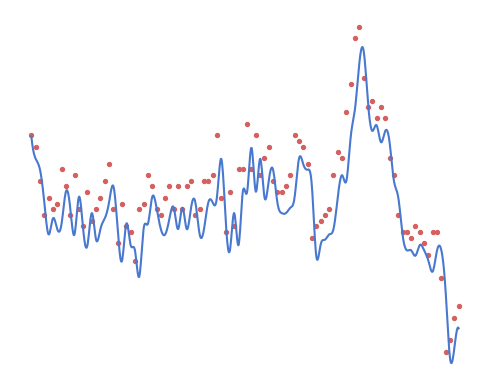

In [75]:
from scipy.interpolate import interp1d

num = 100
n = 12
t = np.linspace(0.01, 0.61, num=num)
median_traj = X_recons

interp_factor = 10
t_new = np.linspace(t.min(), t.max(), len(t) * interp_factor)

f_med = interp1d(t, median_traj[0, n*num:(n+1)*num], kind='cubic')

smooth_median = f_med(t_new)

plt.figure(figsize=(5, 4))

plt.plot(t_new, smooth_median, color='#4878CF', linewidth=1.5, label='Median')

# 测试点
plt.scatter(t[::1], X_traj[0, n*num+1:(n+1)*num+1:1, 0], color='#D65F5F', s=8, linewidths=1.0, label='Test')

# plt.plot(smooth_x, smooth_y, color="#0072B2", linewidth=1.5, label='Reconstructed', zorder=1)

# plt.scatter(
#     t, X_traj[0, 1:751, 0]
#     facecolors='none',
#     edgecolors='#DAA520',
#     s=30,
#     linewidth=1.5,
#     label='Test',
#     zorder=2
# )

plt.axis('off')

plt.tight_layout()
plt.savefig("e3.svg", format='svg', bbox_inches='tight')
plt.show()